In [5]:
pip install numpy opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [10]:
import pandas as pd
import requests


In [13]:
posters_df = pd.read_csv("posters.csv", encoding="latin1")


In [14]:
# Crear carpeta donde se guardarán los pósters
output_folder = "posters/"
os.makedirs(output_folder, exist_ok=True)

# Recorrer el DataFrame
for idx, row in posters_df.iterrows():
    imdb_id = str(row["imdbId"])
    url = row["Poster"]

    # Verificar que la URL no esté vacía o nula
    if pd.isna(url) or not url.startswith("http"):
        print(f"⚠️ Sin URL válida para imdbId {imdb_id}")
        continue

    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(f"{output_folder}/{imdb_id}.jpg", 'wb') as f:
                f.write(response.content)
            print(f"✅ Descargado: {imdb_id}")
        else:
            print(f"❌ Error al descargar {imdb_id} (Status {response.status_code})")
    except Exception as e:
        print(f"⚠️ Falló {imdb_id}: {e}")



✅ Descargado: 114709
✅ Descargado: 113497
❌ Error al descargar 113228 (Status 404)
✅ Descargado: 114885
✅ Descargado: 113041
✅ Descargado: 113277
✅ Descargado: 114319
❌ Error al descargar 112302 (Status 404)
✅ Descargado: 114576
❌ Error al descargar 113189 (Status 404)
✅ Descargado: 112346
✅ Descargado: 112896
✅ Descargado: 112453
✅ Descargado: 113987
✅ Descargado: 112760
✅ Descargado: 112641
✅ Descargado: 114388
✅ Descargado: 113101
✅ Descargado: 112281
✅ Descargado: 113845
✅ Descargado: 113161
✅ Descargado: 112722
❌ Error al descargar 112401 (Status 404)
✅ Descargado: 114168
✅ Descargado: 113627
❌ Error al descargar 114057 (Status 404)
✅ Descargado: 114011
✅ Descargado: 114117
✅ Descargado: 112682
❌ Error al descargar 115012 (Status 404)
✅ Descargado: 112792
✅ Descargado: 114746
✅ Descargado: 114952
✅ Descargado: 112431
✅ Descargado: 112637
✅ Descargado: 112818
✅ Descargado: 112286
✅ Descargado: 113442
❌ Error al descargar 112697 (Status 404)
❌ Error al descargar 112749 (Status 404)


3. Extraer características visuales 

In [1]:

# Carpeta
folder_path = 'posters'

# Configuración
radius = 1
n_points = 8 * radius

# Función para extraer características
def extract_features(image):
    image = resize(image, (128, 128))
    gray = rgb2gray(image)
    gray_uint8 = (gray * 255).astype(np.uint8)

    # RGB Histogram
    hist_rgb = np.concatenate([np.histogram(image[:, :, i], bins=32, range=(0, 1), density=True)[0] for i in range(3)])
    
    # HSV Histogram
    image_uint8 = (image * 255).astype(np.uint8)
    hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV)
    hist_hsv = np.concatenate([np.histogram(hsv[:, :, i], bins=32, range=(0, 255), density=True)[0] for i in range(3)])

    # LBP
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True)

    # GLCM usando mahotas
    glcm_features = mahotas.features.haralick(gray_uint8).mean(axis=0)

    # HOG
    hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    hog_reduced = hog_features[:32]  # Reducido para consistencia

    # Hu Moments
    hu = moments_hu(gray)

    # Zernike Moments
    zernike = zernike_moments(gray_uint8, radius=64, degree=8)

    return np.concatenate([hist_rgb, hist_hsv, lbp_hist, glcm_features, hog_reduced, hu, zernike])

# Extraer de todas las imágenes
features = []
image_names = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        path = os.path.join(folder_path, filename)
        image = imread(path)
        try:
            feats = extract_features(image)
            features.append(feats)
            image_names.append(filename)
        except Exception as e:
            print(f"Error con {filename}: {e}")

# Matriz
features_array = np.array(features)

# Métricas comparativas
metrics = {
    'Media STD por vector': np.std(features_array, axis=1).mean(),
    'Media Skew por vector': np.mean(skew(features_array, axis=1, nan_policy='omit')),
    'Media Kurtosis por vector': np.mean(kurtosis(features_array, axis=1, nan_policy='omit'))
}

# Resultados
df_metrics = pd.DataFrame([metrics])
print(df_metrics)

# Opcional: guardar las características
df_features = pd.DataFrame(features_array)
df_features['image'] = image_names
df_features.to_csv('features_extracted.csv', index=False)


NameError: name 'os' is not defined

4. Reducción de dimensionalidad

PCA

In [24]:
import numpy as np

def pca_manual(X, n_components=2):
    # Centrar los datos (restar la media)
    X_meaned = X - np.mean(X, axis=0)

    # Calcular la matriz de covarianza
    covariance_matrix = np.cov(X_meaned, rowvar=False)

    # Obtener eigenvalores y eigenvectores
    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

    # Ordenar de mayor a menor según los eigenvalores
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
    
    # Tomar los primeros n_components
    eigenvector_subset = sorted_eigenvectors[:, :n_components]

    # Proyectar los datos originales al nuevo espacio
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    return X_reduced

# Aplicar PCA a tus vectores de características
features_reduced = pca_manual(features, n_components=2)

print("\n📉 Reducción completada")
print("Nueva forma de los datos:", features_reduced.shape)



📉 Reducción completada
Nueva forma de los datos: (29066, 2)


SVD

In [25]:
def svd_manual(X, n_components=50):
    
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    X_reduced = np.dot(U[:, :n_components], np.diag(S[:n_components]))
    return X_reduced

features_svd_50 = svd_manual(features, n_components=50)

print("SVD completado. Nueva forma:", features_svd_50.shape)

SVD completado. Nueva forma: (29066, 50)


COMPARACIÓN PCA Y SVD

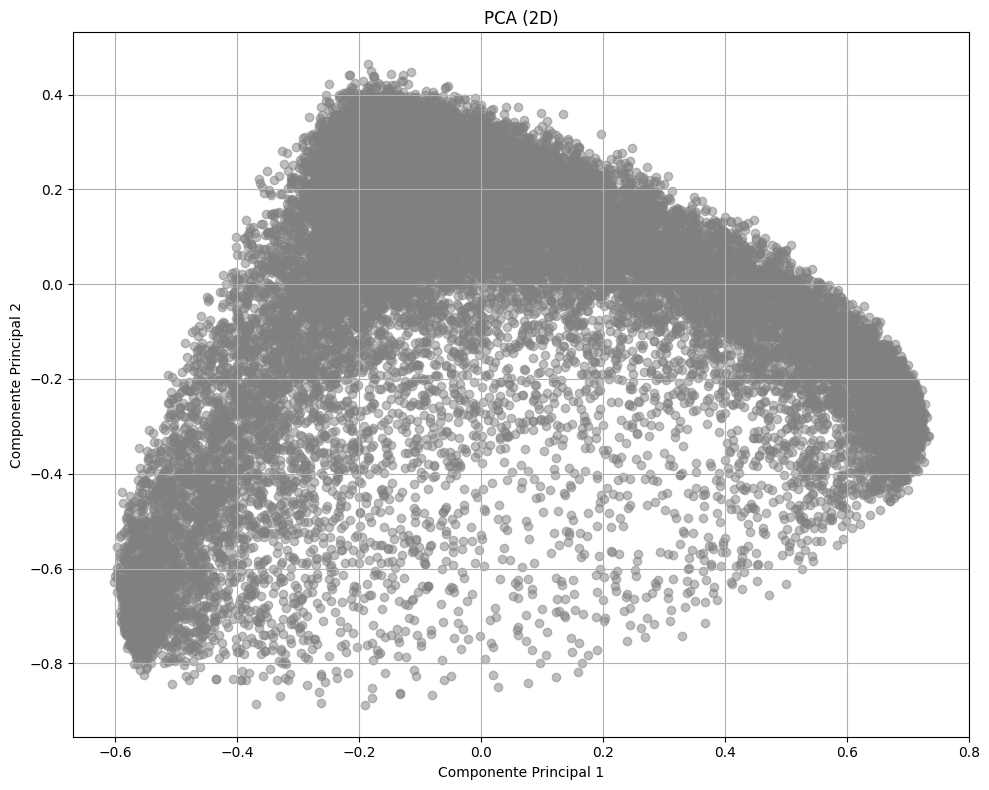

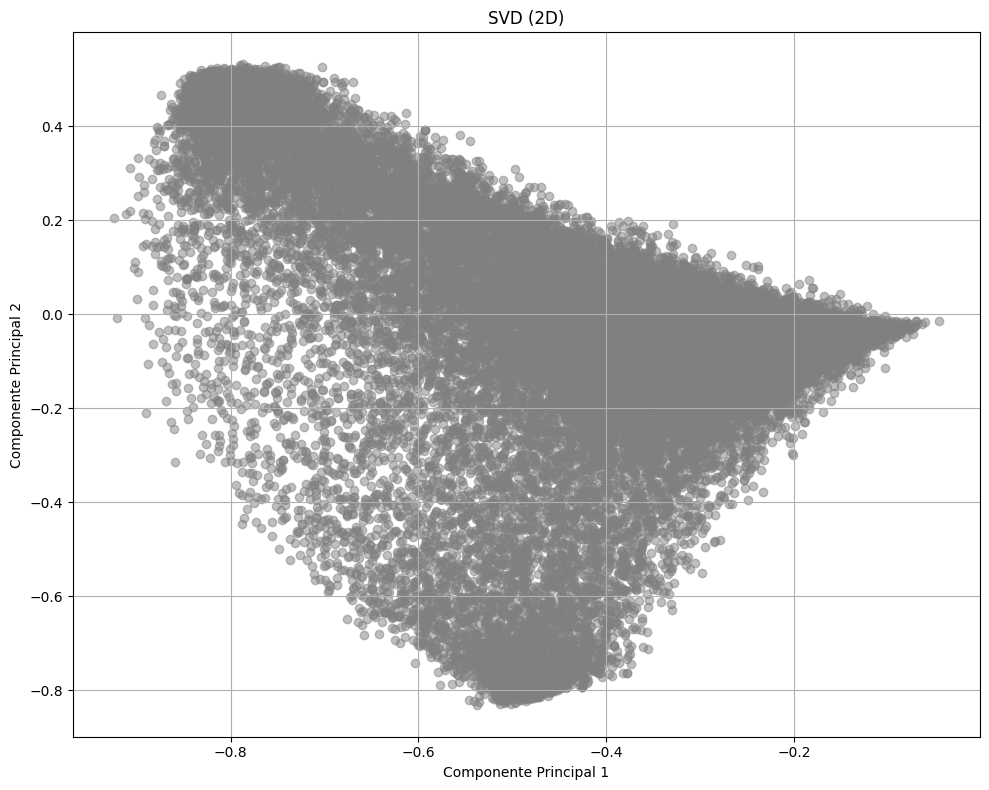

In [26]:
# Aplica PCA y SVD a 2D
features_pca_2d = pca_manual(features, n_components=2)
features_svd_2d = svd_manual(features, n_components=2)

# Visualización
plot_2d(features_pca_2d, title="PCA (2D)")
plot_2d(features_svd_2d, title="SVD (2D)")


In [19]:
features_pca_50 = pca_manual(features, n_components=50)


5. Implementar algoritmos de agrupamiento

K-MEANS

In [20]:
import numpy as np

def kmeans_manual(X, k=10, max_iters=100, tol=1e-4):
    np.random.seed(42)
    n_samples = X.shape[0]

    # Inicializar centroides aleatoriamente desde los datos
    centroids = X[np.random.choice(n_samples, k, replace=False)]

    for iteration in range(max_iters):
        # Asignación: calcular distancias y asignar a cluster más cercano
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # [n_samples, k]
        labels = np.argmin(distances, axis=1)  # [n_samples]

        # Actualización de centroides
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k)])

        # Ver si los centroides cambiaron significativamente
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids

        print(f"Iteración {iteration+1}, cambio total de centroides: {shift:.4f}")
        if shift < tol:
            break

    return labels, centroids


In [21]:
k = 10  # puedes ajustar
labels_kmeans, centroids_kmeans = kmeans_manual(features_pca_50, k=k)


Iteración 1, cambio total de centroides: 1.4285
Iteración 2, cambio total de centroides: 0.3768
Iteración 3, cambio total de centroides: 0.2005
Iteración 4, cambio total de centroides: 0.1700
Iteración 5, cambio total de centroides: 0.0954
Iteración 6, cambio total de centroides: 0.0712
Iteración 7, cambio total de centroides: 0.0576
Iteración 8, cambio total de centroides: 0.0580
Iteración 9, cambio total de centroides: 0.0598
Iteración 10, cambio total de centroides: 0.0628
Iteración 11, cambio total de centroides: 0.0566
Iteración 12, cambio total de centroides: 0.0500
Iteración 13, cambio total de centroides: 0.0430
Iteración 14, cambio total de centroides: 0.0387
Iteración 15, cambio total de centroides: 0.0320
Iteración 16, cambio total de centroides: 0.0191
Iteración 17, cambio total de centroides: 0.0146
Iteración 18, cambio total de centroides: 0.0117
Iteración 19, cambio total de centroides: 0.0092
Iteración 20, cambio total de centroides: 0.0061
Iteración 21, cambio total de

In [27]:
features_pca_2d = pca_manual(features, n_components=2)
features_svd_2d = svd_manual(features, n_components=2)


In [28]:
def plot_2d(features_2d, labels=None, title=""):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 8))
    if labels is not None:
        unique_labels = np.unique(labels)
        for label in unique_labels:
            cluster_points = features_2d[labels == label]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=0.6)
        plt.legend()
    else:
        plt.scatter(features_2d[:, 0], features_2d[:, 1], color="gray", alpha=0.5)

    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


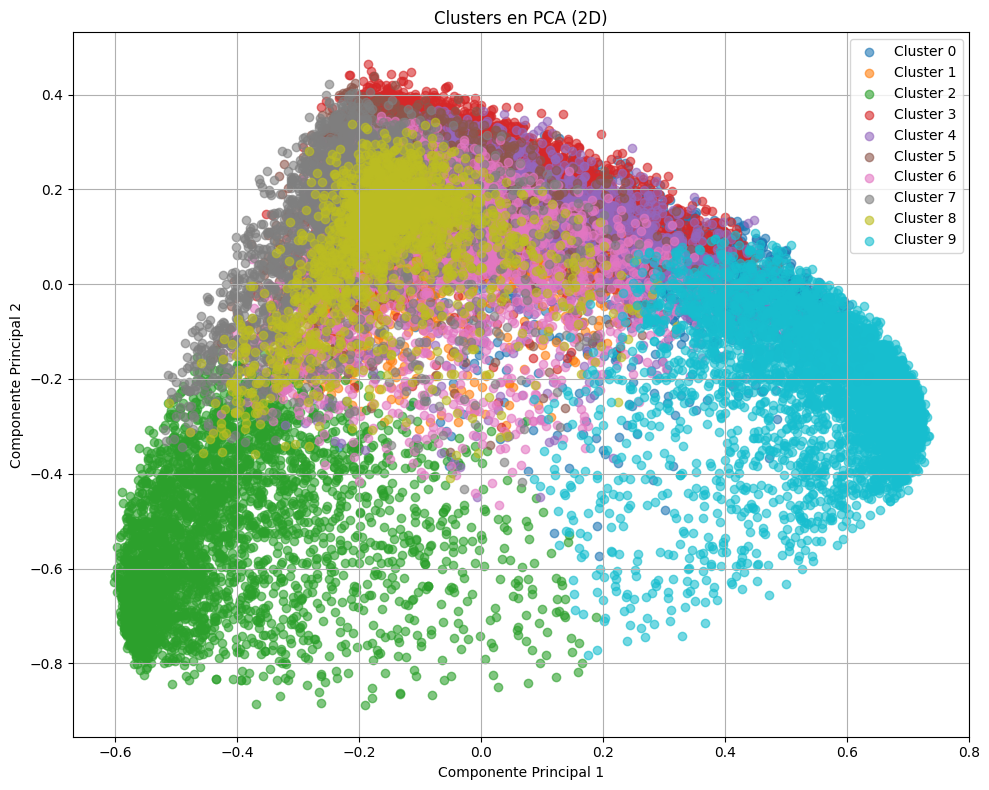

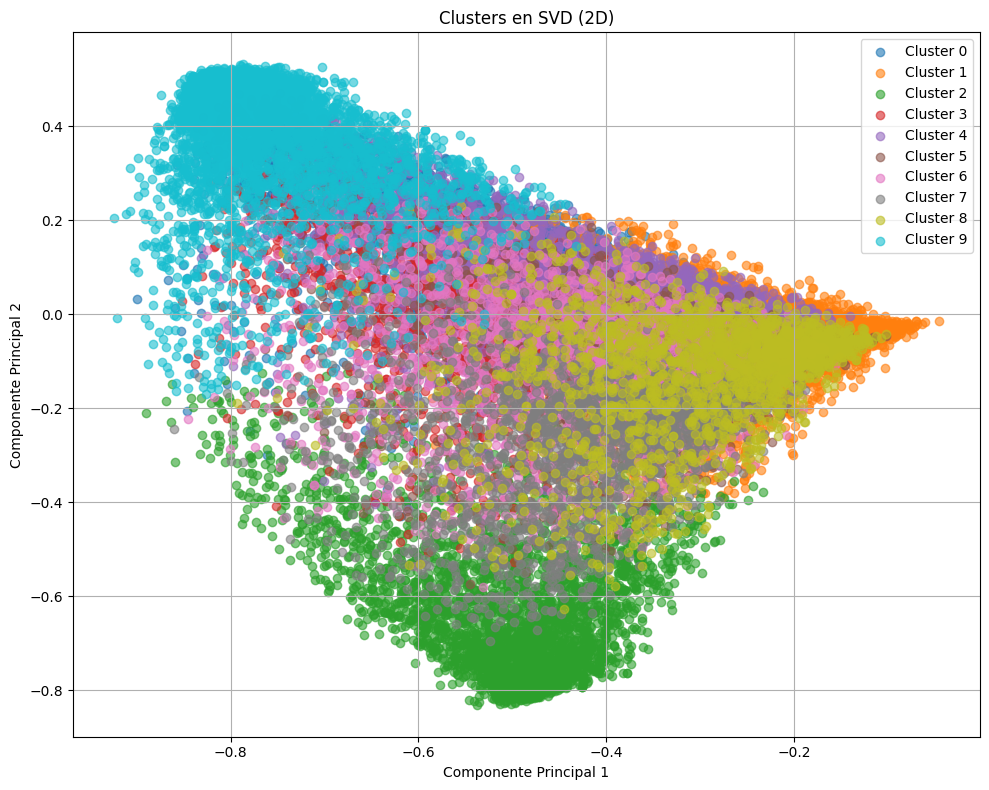

In [29]:
plot_2d(features_pca_2d, labels=labels_kmeans, title="Clusters en PCA (2D)")
plot_2d(features_svd_2d, labels=labels_kmeans, title="Clusters en SVD (2D)")


In [30]:
import numpy as np

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def dbscan(X, eps=0.2, min_samples=5):
    n = len(X)
    labels = np.full(n, -1)  # -1 para noise
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    def region_query(i):
        distances = np.linalg.norm(X - X[i], axis=1)
        return np.where(distances <= eps)[0]

    def expand_cluster(i, neighbors):
        labels[i] = cluster_id
        j = 0
        while j < len(neighbors):
            point = neighbors[j]
            if not visited[point]:
                visited[point] = True
                new_neighbors = region_query(point)
                if len(new_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
            if labels[point] == -1:
                labels[point] = cluster_id
            j += 1

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1  # noise
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels


DBSCAN EPS=0.3

In [ ]:
labels_dbscan = dbscan(features_pca_50, eps=0.3, min_samples=10)


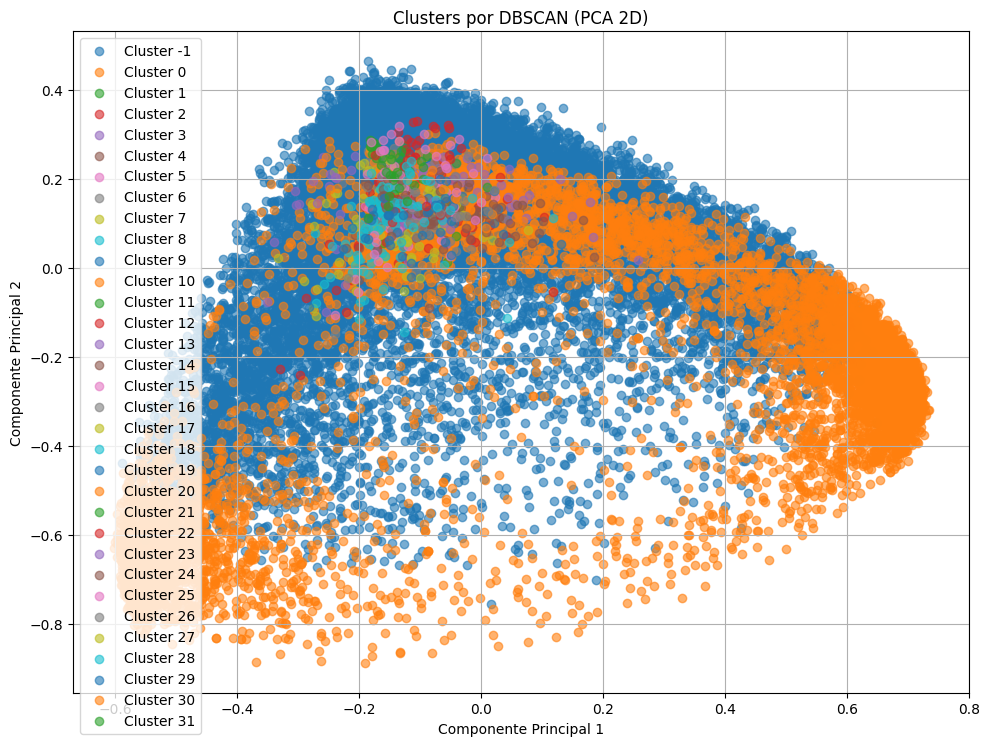

In [32]:
plot_2d(features_reduced, labels=labels_dbscan, title="Clusters por DBSCAN (PCA 2D)")


DBSCAN EPS=0.4

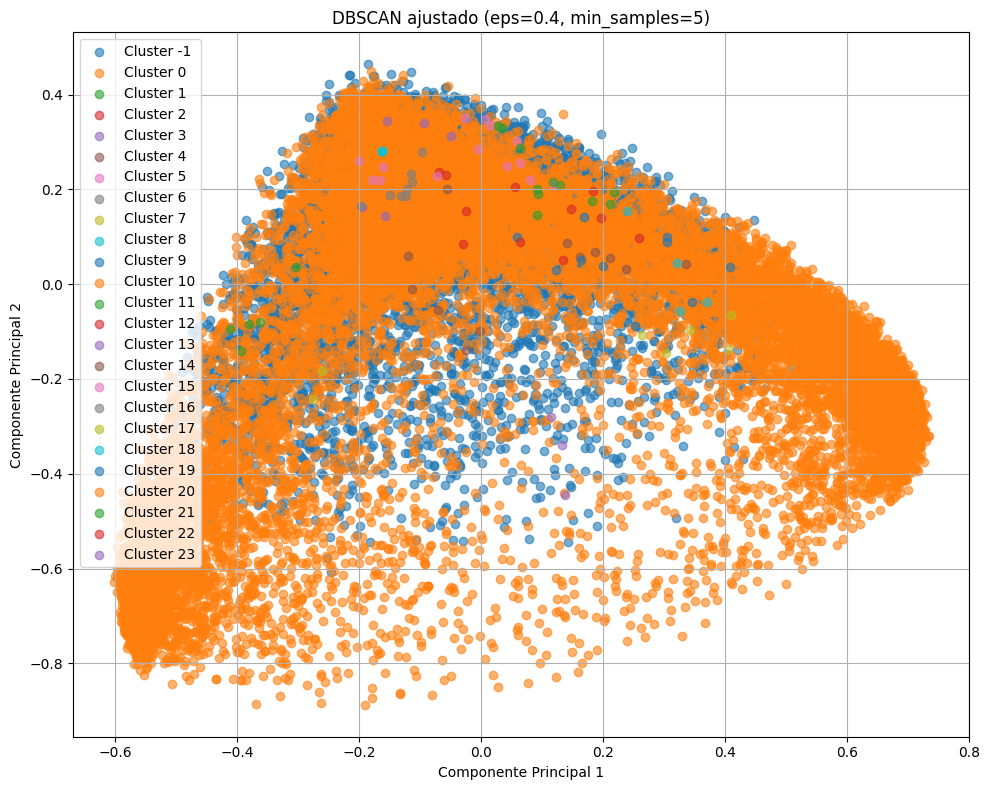

In [33]:
# Ajuste de parámetros
labels_dbscan_adjusted = dbscan(features_pca_50, eps=0.4, min_samples=5)

# Visualización con los nuevos resultados
plot_2d(features_reduced, labels=labels_dbscan_adjusted, title="DBSCAN ajustado (eps=0.4, min_samples=5)")


In [35]:
import numpy as np

unique, counts = np.unique(labels_dbscan_adjusted, return_counts=True)

# Mostrar resultado
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} puntos")


Cluster -1: 9446 puntos
Cluster 0: 19519 puntos
Cluster 1: 5 puntos
Cluster 2: 3 puntos
Cluster 3: 3 puntos
Cluster 4: 6 puntos
Cluster 5: 10 puntos
Cluster 6: 4 puntos
Cluster 7: 2 puntos
Cluster 8: 5 puntos
Cluster 9: 6 puntos
Cluster 10: 3 puntos
Cluster 11: 7 puntos
Cluster 12: 4 puntos
Cluster 13: 2 puntos
Cluster 14: 6 puntos
Cluster 15: 4 puntos
Cluster 16: 4 puntos
Cluster 17: 5 puntos
Cluster 18: 4 puntos
Cluster 19: 4 puntos
Cluster 20: 3 puntos
Cluster 21: 4 puntos
Cluster 22: 4 puntos
Cluster 23: 3 puntos


DBSCAN MENOS PERMISIVO

C:\Users\mayri\AppData\Local\Temp\ipykernel_13444\1624160711.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


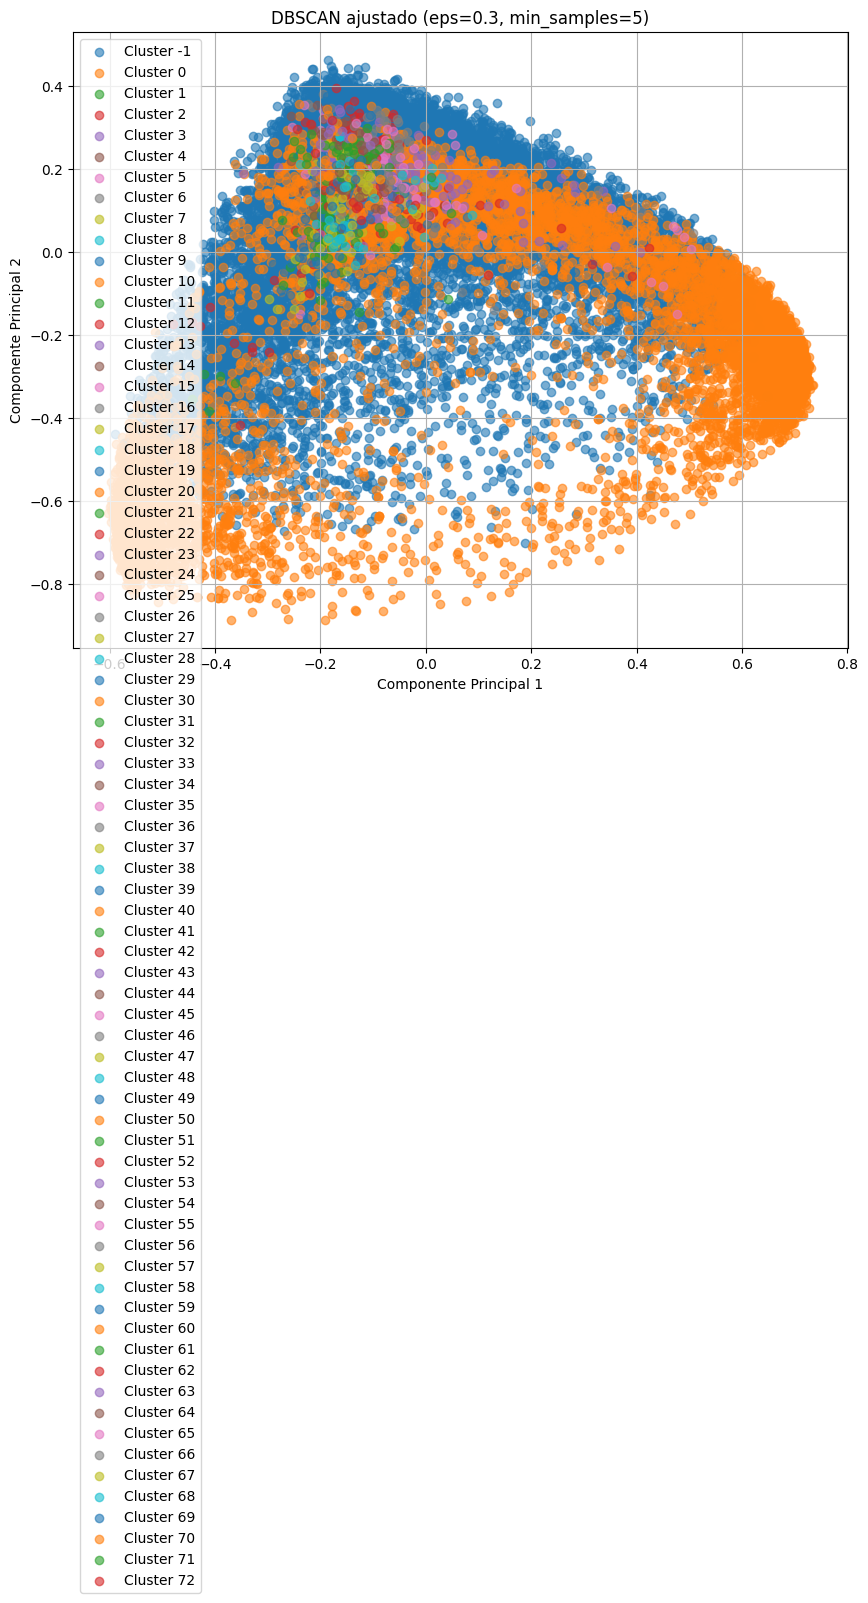

In [36]:
labels_dbscan_strict = dbscan(features_pca_50, eps=0.3, min_samples=5)
plot_2d(features_reduced, labels=labels_dbscan_strict, title="DBSCAN ajustado (eps=0.3, min_samples=5)")


In [38]:
unique, counts = np.unique(labels_dbscan_strict, return_counts=True)

# Mostrar resultado
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} puntos")

Cluster -1: 18699 puntos
Cluster 0: 8982 puntos
Cluster 1: 45 puntos
Cluster 2: 147 puntos
Cluster 3: 204 puntos
Cluster 4: 7 puntos
Cluster 5: 80 puntos
Cluster 6: 35 puntos
Cluster 7: 44 puntos
Cluster 8: 17 puntos
Cluster 9: 107 puntos
Cluster 10: 24 puntos
Cluster 11: 48 puntos
Cluster 12: 23 puntos
Cluster 13: 10 puntos
Cluster 14: 5 puntos
Cluster 15: 27 puntos
Cluster 16: 30 puntos
Cluster 17: 27 puntos
Cluster 18: 5 puntos
Cluster 19: 31 puntos
Cluster 20: 57 puntos
Cluster 21: 20 puntos
Cluster 22: 7 puntos
Cluster 23: 11 puntos
Cluster 24: 11 puntos
Cluster 25: 8 puntos
Cluster 26: 9 puntos
Cluster 27: 17 puntos
Cluster 28: 15 puntos
Cluster 29: 11 puntos
Cluster 30: 6 puntos
Cluster 31: 10 puntos
Cluster 32: 22 puntos
Cluster 33: 5 puntos
Cluster 34: 13 puntos
Cluster 35: 5 puntos
Cluster 36: 13 puntos
Cluster 37: 7 puntos
Cluster 38: 5 puntos
Cluster 39: 9 puntos
Cluster 40: 27 puntos
Cluster 41: 25 puntos
Cluster 42: 6 puntos
Cluster 43: 2 puntos
Cluster 44: 7 puntos
Clust

C:\Users\mayri\AppData\Local\Temp\ipykernel_13444\1624160711.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


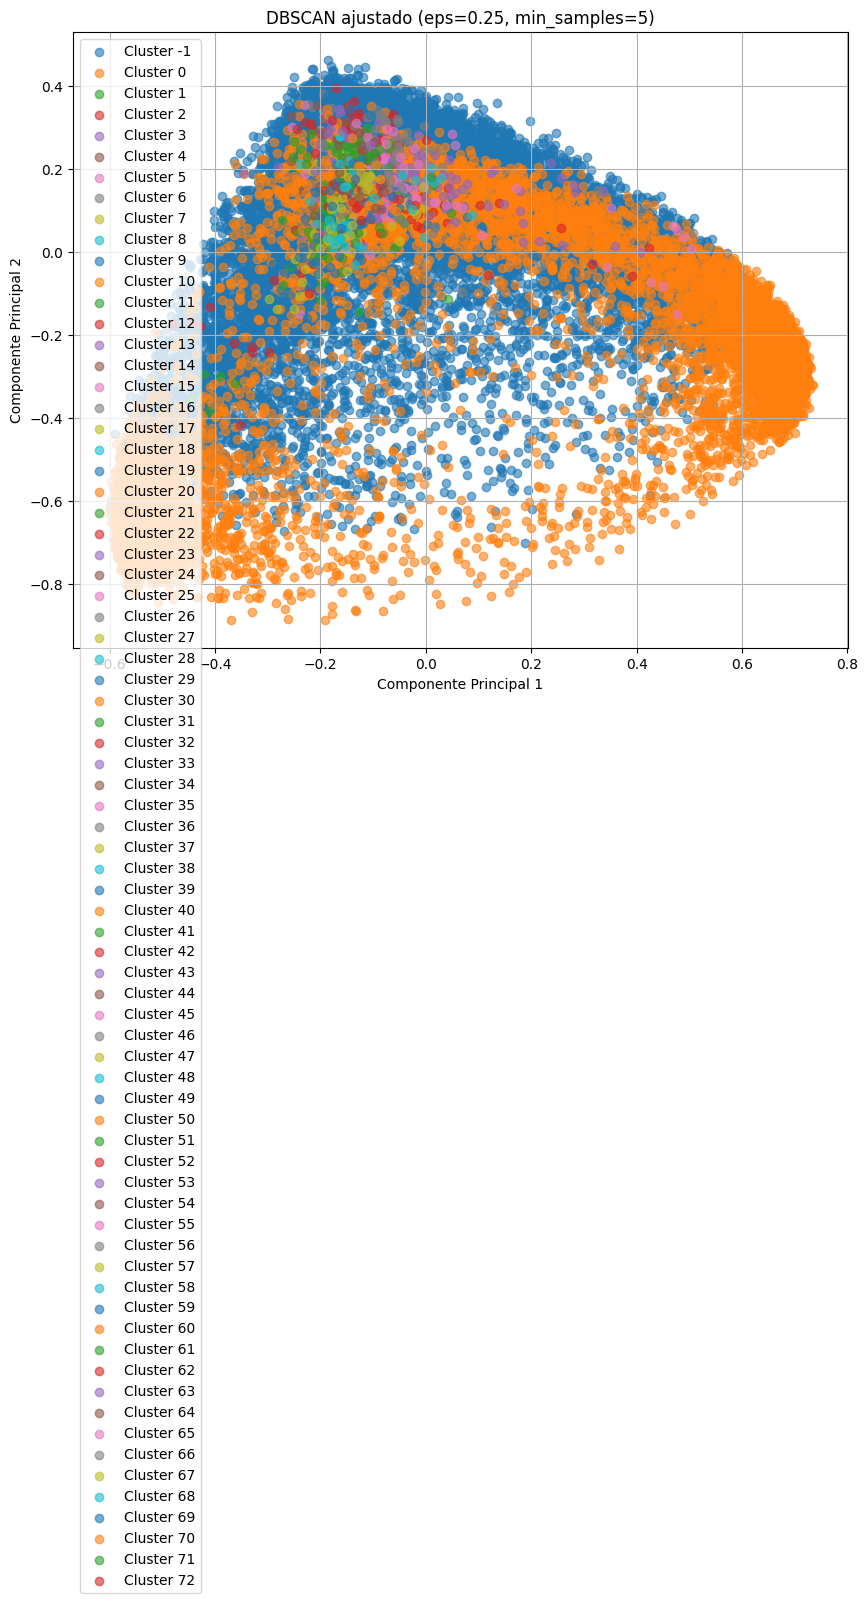

In [39]:
labels_dbscan_strict_2 = dbscan(features_pca_50, eps=0.3, min_samples=5)
plot_2d(features_reduced, labels=labels_dbscan_strict, title="DBSCAN ajustado (eps=0.25, min_samples=5)")

In [40]:
unique, counts = np.unique(labels_dbscan_strict_2, return_counts=True)

# Mostrar resultado
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} puntos")

Cluster -1: 18699 puntos
Cluster 0: 8982 puntos
Cluster 1: 45 puntos
Cluster 2: 147 puntos
Cluster 3: 204 puntos
Cluster 4: 7 puntos
Cluster 5: 80 puntos
Cluster 6: 35 puntos
Cluster 7: 44 puntos
Cluster 8: 17 puntos
Cluster 9: 107 puntos
Cluster 10: 24 puntos
Cluster 11: 48 puntos
Cluster 12: 23 puntos
Cluster 13: 10 puntos
Cluster 14: 5 puntos
Cluster 15: 27 puntos
Cluster 16: 30 puntos
Cluster 17: 27 puntos
Cluster 18: 5 puntos
Cluster 19: 31 puntos
Cluster 20: 57 puntos
Cluster 21: 20 puntos
Cluster 22: 7 puntos
Cluster 23: 11 puntos
Cluster 24: 11 puntos
Cluster 25: 8 puntos
Cluster 26: 9 puntos
Cluster 27: 17 puntos
Cluster 28: 15 puntos
Cluster 29: 11 puntos
Cluster 30: 6 puntos
Cluster 31: 10 puntos
Cluster 32: 22 puntos
Cluster 33: 5 puntos
Cluster 34: 13 puntos
Cluster 35: 5 puntos
Cluster 36: 13 puntos
Cluster 37: 7 puntos
Cluster 38: 5 puntos
Cluster 39: 9 puntos
Cluster 40: 27 puntos
Cluster 41: 25 puntos
Cluster 42: 6 puntos
Cluster 43: 2 puntos
Cluster 44: 7 puntos
Clust

Comparación de resultados

In [46]:
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Asegúrate de que estas variables ya existen con tus datos reales:
# features_pca_50: tu matriz de características (ej. PCA de 50 dimensiones)
# labels_kmeans_manual: etiquetas del clustering con K-Means manual
# labels_dbscan_strict: etiquetas del DBSCAN con eps más estricto (ej. 0.3)
# labels_dbscan_strict_2: etiquetas del DBSCAN con otro ajuste (ej. eps=0.35)

# Función auxiliar para calcular Silhouette Score solo en puntos válidos (no -1)
def safe_silhouette(X, labels):
    n_labels = len(set(labels)) - (1 if -1 in labels else 0)
    if n_labels < 2:
        return np.nan
    mask = np.array(labels) != -1
    return silhouette_score(X[mask], np.array(labels)[mask]) if np.sum(mask) > 1 else np.nan

# Cálculo de métricas
results = {
    "K-Means Manual": {
        "Silhouette Score": safe_silhouette(features_pca_50, labels_kmeans),
        "Rand Index": adjusted_rand_score(labels_kmeans, labels_kmeans),
        "Mutual Info": normalized_mutual_info_score(labels_kmeans, labels_kmeans)
    },
    "DBSCAN Estricto 1": {
        "Silhouette Score": safe_silhouette(features_pca_50, labels_dbscan_strict),
        "Rand Index": adjusted_rand_score(labels_kmeans, labels_dbscan_strict),
        "Mutual Info": normalized_mutual_info_score(labels_kmeans, labels_dbscan_strict)
    },
    "DBSCAN Estricto 2": {
        "Silhouette Score": safe_silhouette(features_pca_50, labels_dbscan_strict_2),
        "Rand Index": adjusted_rand_score(labels_kmeans, labels_dbscan_strict_2),
        "Mutual Info": normalized_mutual_info_score(labels_kmeans, labels_dbscan_strict_2)
    }
}

# Mostrar resultados
print("\nComparación de métricas internas entre métodos de agrupamiento:\n")
for metodo, metricas in results.items():
    print(f" {metodo}")
    for nombre_metrica, valor in metricas.items():
        print(f"   {nombre_metrica}: {valor:.4f}")
    print()




Comparación de métricas internas entre métodos de agrupamiento:

 K-Means Manual
   Silhouette Score: -0.0044
   Rand Index: 1.0000
   Mutual Info: 1.0000

 DBSCAN Estricto 1
   Silhouette Score: -0.0043
   Rand Index: -0.0000
   Mutual Info: 0.0002

 DBSCAN Estricto 2
   Silhouette Score: -0.0083
   Rand Index: -0.0000
   Mutual Info: 0.0004

